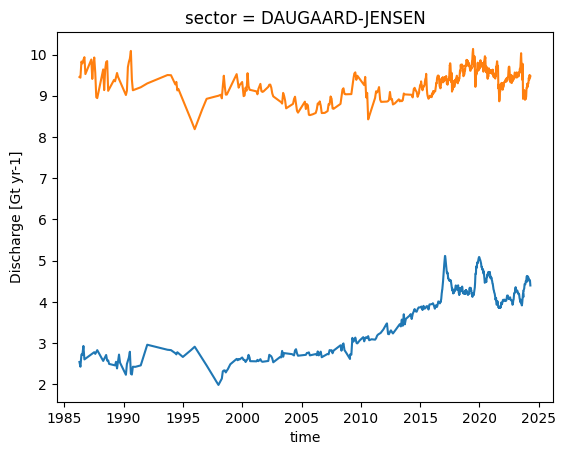

In [10]:
import xarray as xr

# xr.open_dataset("../data/discharge/gate.nc")
# xr.open_dataset("../data/discharge/GIS.nc")
# xr.open_dataset("../data/discharge/region.nc")
xr.open_dataset("../data/discharge/sector.nc").load().sel(
    sector="UNNAMED_UUNARTIT_ISLANDS"
).discharge.plot()
xr.open_dataset("../data/discharge/sector.nc").load().sel(
    sector="DAUGAARD-JENSEN"
).discharge.plot()

## runoff
- Download data from [Mankoff, 2020](https://doi.org/10.22008/FK2/XKQVL7) using the below command:

`wget -r -e robots=off -nH --cut-dirs=3 --content-disposition "https://dataverse.geus.dk/api/datasets/:persistentId/dirindex?persistentId=doi:10.22008/FK2/XKQVL7"`

In [ ]:
def read_filter(path, ids, date_filter=pd.Timestamp("2010-12-31"), var="discharge"):
    """
    helper for opening and filtering runoff .nc files
    path - file path to .nc file
    ids  list of catchments ids to select
    date_filter (pd.Timestamp) default 31st Dec 2010, only select times after this date
    var (str) name of variable in .nc files to select. default: discharge
    returns filtered, chunked, data array
    """
    name = Path(path).stem
    with xr.open_dataset(path, chunks={"time": -1, "station": 1000}) as ds:
        ds = (
            ds.sel(
                station=ds["station"].isin(ids),  # select catchment ids
                time=ds["time"] >= date_filter,  # filter on time
            )[var]
            .assign_coords(model=name)  # add new dimension for model name
            .expand_dims("model")
        )
        return ds

In [ ]:
# read in basins and outlet points
basins = gpd.read_file("../data/runoff/freshwater/ice/basins.gpkg")
outlets = gpd.read_file("../data/runoff/freshwater/ice/outlets.gpkg")

# identify which catchments intersect with centrelines, and in the case of multiple, catchments, pick the biggest.
intersection = basins.sjoin(gpd.GeoDataFrame(cl))
basin_selection = intersection.loc[intersection.groupby("index_right")["area"].idxmax()]
outlet_selection = outlets.loc[outlets["cat"].isin(basin_selection["cat"])]

ids = basin_selection["cat"].values.tolist()
# mapping between cat-id and glacier name
id_glac = dict(zip(ids, basin_selection["index_right"]))

# open .nc files, filter on station id, and date, compute average of the two rcm models
paths = glob("../data/runoff/freshwater/ice/*.nc")
ncfiles = [h.read_filter(file, ids) for file in paths]
ncfiles = [ds.compute() for ds in ncfiles]

d = xr.concat(ncfiles, dim="model")
model_avg = d.mean(dim="model").assign_coords(model=("average")).expand_dims("model")
d = xr.concat([d, model_avg], dim="model")

# get cumulative annual runoffs
cumulative = (d * 60 * 60 * 24).groupby(d.time.dt.year).cumsum()

# set first of each year to np.nan, for tidier plotting
idx = (cumulative.time.dt.month == 1) & (cumulative.time.dt.day == 1)
cumulative[:, :, idx] = np.nan

# for easier plotting
# convert racmo, mar, and average cumulative runoffs to their own pandas dataframe
cml_racmo, cml_mar, cml_avg = [
    (cumulative[i, :, :].to_pandas().T.rename(columns=id_glac).reset_index()) for i in range(3)
]

In [ ]:
### plotting
from cycler import cycler
from matplotlib.dates import DateFormatter, date2num
from matplotlib.ticker import AutoMinorLocator

clist = sns.palettes.color_palette("colorblind")
custom_cycler = cycler(color=clist)
date_fmt = DateFormatter("%Y")
linestyles = dict(zip(list(id_glac.values()), ["-", "--"]))

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=[8, 5])

axs[0].set_prop_cycle(custom_cycler)
axs[1].set_prop_cycle(custom_cycler)

# plot cumulative annual average
for g in list(id_glac.values()):
    axs[0].plot(cml_avg["time"], cml_avg[g], label=g, linestyle=linestyles[g])

    # shade model range
    axs[0].fill_between(x=cml_avg["time"], y1=cml_racmo[g], y2=cml_mar[g], alpha=0.5)

############ plot daily.
# plotting them separately to allow for line different line styles
d[2, 0, :].resample(time="5d").mean().plot(
    color=clist[1], linestyle=":", ax=axs[1], add_legend=False
)
d[2, 1, :].resample(time="5d").mean().plot(
    color=clist[0], linestyle="-", ax=axs[1], add_legend=False
)

########################## formatting
sns.despine(fig, trim=True)
labs = "abcdefg"
for i, ax in enumerate(axs):
    ax.set_xticks(pd.date_range("2010-01-01", "2022-01-01", freq="2AS"))
    ax.set_xlim(left=pd.Timestamp("2010-10-30"))
    ax.spines["bottom"].set_bounds(
        low=date2num(pd.Timestamp("2011-01-01")), high=date2num(pd.Timestamp("2022-01-01"))
    )

    plt.xticks(rotation=0, ha="center")
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(date_fmt)
    ax.annotate(f"({labs[i]})", xy=(0.04, 0.84), xycoords="axes fraction", fontsize=18)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05)

axs[0].legend(
    ncols=1, bbox_to_anchor=(0.95, 1.05), loc="upper right", frameon=False  # title='glacier',
)
axs[0].ticklabel_format(axis="y", style="sci", useMathText=True)
offset = axs[0].yaxis.get_major_formatter().get_offset()
axs[0].yaxis.offsetText.set_visible(False)
axs[0].set_ylabel(f"Cumulative\nrunoff ({offset} m$^3$)")

axs[1].set_title("")
axs[1].set_ylabel("Runoff rate\n(m$^3$ s$^{-1}$)")
axs[1].set_xlabel("Year")
axs[1].spines["left"].set_bounds(high=400)
axs[1].set_ylim(top=405)
axs[1].set_yticks(np.arange(0, 500, 100))

fig.savefig("../figures/f07", bbox_inches="tight")
print(
    "Figure 7: Cumulative (a) and average daily runoff rate (b) at Isortuarsuup Sermia (solid blue lines)\n\
    and Kangaasarsuup Sermia (dashed orange lines). In (a) lines represent the average of the two RCMs, \n\
        shading denotes range of model values. In (b) lines show rolling 5-day average."
)